### D. Heslop, U. Amarathunga and E. J. Rohling (2023). North African Plio-Pleistocene monsoon runoff and its impacts on the Mediterranean Sea. Paleoceanography and Paleoclimatology (submitted).

#### Jupyter notebook to perform quantile regression and recreate Figures 3, 5, 6, and 7.

#### Import libraries

In [1]:
import shutil
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator as pchip

#### Test if LaTeX is installed and can be used in plots (labels look nicer in LaTeX)

In [2]:
plt.rcParams['text.usetex']= True if shutil.which('latex') else False

#### Define a colorblind-friendly color scheme

In [3]:
CB = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']

#### Define the regression expression (cubic spline with 50 degrees of freedom)

In [4]:
dof = 50 #use 50 dof to include Milankovitch 
regexp = "Y ~ cr(X,df=" + str(dof) + ")" #expression to define model in statsmodel

#### Function to perform regression conditional on a given quantile (```q```)
Uses the ```statmodels``` package to fit a cubic spline with a user-defined number of degrees of freedom

output[0] is a pchip representation of the spline for the estimated quantile as a function of age

output[1] is a pchip representation of the spline for the estimated standard error as a function of age 

In [5]:
def quantfit(df,regexp,q):
    mod = smf.quantreg(regexp, df)
    res = mod.fit(q)
    fit_pp = pchip(df['X'],res.predict())
    
    predictions = res.get_prediction()
    frame = predictions.summary_frame(alpha=0.05)
    upper = frame.mean_ci_upper
    lower = frame.mean_ci_lower
    se_pp = pchip(df['X'],(upper-lower)/3.92)
    
    return [fit_pp,se_pp]

#### Import ODP Site 967 $\delta^{18}O_{\textrm{pf}}$ and interpolate onto regular (1 kyr) time intervals
Interpolation is required because marls ages are defined with a 1 kyr precision

In [6]:
X = np.loadtxt('ODP967 - d18O.csv',delimiter=',');
age0 = X[:,0];
dc0 = X[:,1];

age = np.arange(4,5123,1)
dc = np.interp(age,age0,dc0)

#### Import ODP Site 967 marl ages and identify points in the time series corresponding to marls (set to ```Midx==1```)

In [7]:
Mages = np.loadtxt('ODP967 - Nonsapropel ages.csv',delimiter=',');
Midx = np.zeros(np.shape(age));

for i in range(np.size(age)):
    if np.min(np.abs(age[i]-Mages))<0.1:
        Midx[i] = 1;

#### Import Rohling et al. (2021) ESL and convert to RSL$_{Gib}$ using the expression from Rohling et al. (2014)

In [8]:
SL = np.loadtxt('Rohling2021 - ESL.csv',delimiter=',');
SL[:,0] *= -1;
SL[:,1] /= 1.23
SL = np.flipud(SL[:, SL[0, :].argsort()])
sl = np.interp(age,SL[:,1],SL[:,0])

#### Load Laskar et al. (2004) ecccentricty and fit median using quantfit (```E50```)

In [9]:
X = np.loadtxt('Laskar2004 - Eccentricity.csv',delimiter=',');
E50 = quantfit({'X':X[:,0],'Y':X[:,1]},regexp,0.5)

#### Estimate 0.1 quantile in $\delta^{18}O_{\textrm{pf}}$ for marls (```dcM10```) and sapropels (```dcS10```)

In [10]:
#pchip representation of d18O 0.1 quantile in marls
dcM10 = quantfit({'X':age[Midx==1],'Y':dc[Midx==1]},regexp,0.1)

#form pchip representation of d18O 10th percentile in sapropels
dcS10 = quantfit({'X':age[Midx==0],'Y':dc[Midx==0]},regexp,0.1)

/Users/dave/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


#### Estimate RSL$_{Gib}$ 0.9 quantiles for marls (```slM90```) and sapropels (```slS90```)

In [11]:
#form pchip representation for RLS_Gib 0.9 quantile in marls
slM90 = quantfit({'X':age[Midx==1],'Y':sl[Midx==1]},regexp,0.9)

#form pchip representation for RLS_Gib 0.9 quantile in sapropels
slS90 = quantfit({'X':age[Midx==0],'Y':sl[Midx==0]},regexp,0.9)

/Users/dave/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


#### Define large gaps in the ODP Site 967 $\delta^{18}O_{\textrm{pf}}$ time series that need to be shown in plots 

In [12]:
#Ages of gaps
H = np.zeros((2,2))
H[0,:] = [2938,3037]
H[1,:] = [4148,4230.5]

#corresponding knots in quantile regression cubic spline
knots = np.linspace(age[0],age[-1],dof)
idx0 = np.max(np.argwhere(knots<=H[0,0]))
idx1 = np.min(np.argwhere(knots>=H[0,1]))

K = np.zeros((2,2))
K[0,:] = [knots[idx0],knots[idx1]]

idx0 = np.max(np.argwhere(knots<=H[1,0]))
idx1 = np.min(np.argwhere(knots>=H[1,1]))

K[1,:] = [knots[idx0],knots[idx1]]

### Recreate Figure 3
#### Top panel (a) - plot of $\delta^{18}O_{\textrm{pf}}$ quantiles as bands (representing 95% uncertainty as $\pm$1.96 se)
Blue = $\delta^{18}O_{\textrm{pf}}$ in sapropels

Black = $\delta^{18}O_{\textrm{pf}}$ in sapropels

Orange = 0.1 quantile of $\delta^{18}O_{\textrm{pf}}$ in marls

Green = 0.1 quantile of $\delta^{18}O_{\textrm{pf}}$ in sapropels

#### Bottom panel (b) - plots of RSL$_{\textrm{Gib}}$ quantiles as bands (representing 95% uncertainty as $\pm$1.96 se)
Black = RSL$_{Gib}$ time series

Orange = 0.9 quantile of RSL$_{\textrm{Gib}}$ in marls

Green = 0.9 quantile of RSL$_{\textrm{Gib}}$ in sapropels

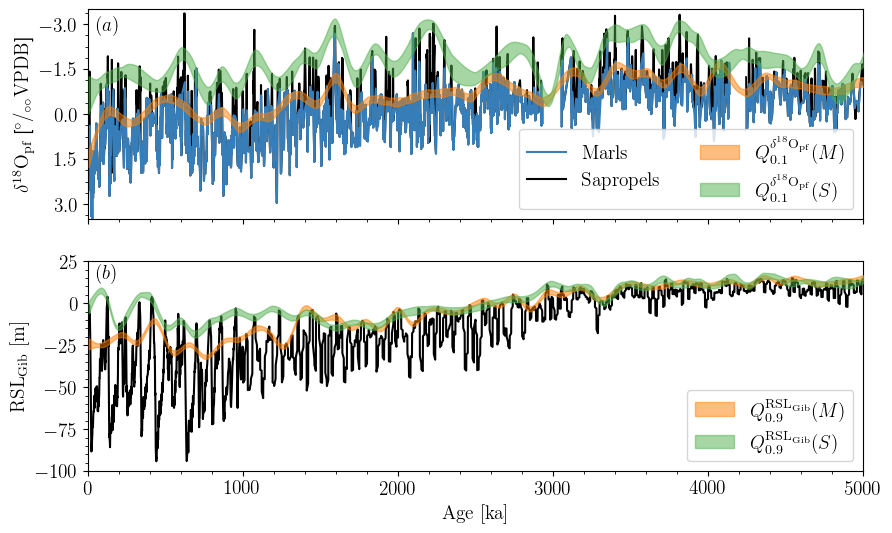

In [13]:
#Set up figure
fontsize = 14
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,figsize=(10,6))

#Plot (a)
ax1.plot(age[Midx==1],dc[Midx==1],color=CB[0],zorder=2,label=r"$\mathrm{Marls}$")
ax1.plot(age,dc,'k',zorder=1,label=r"$\mathrm{Sapropels}$")
ax1.set_xlim([0,5000])
ax1.fill_between(age,dcM10[0](age)-1.96*dcM10[1](age),dcM10[0](age)+1.96*dcM10[1](age),color=CB[1],zorder=4,alpha=0.5,label=r"$Q_{0.1}^{\delta^{18}\mathrm{O_{pf}}} (M)$")
ax1.fill_between(age,dcS10[0](age)-1.96*dcS10[1](age),dcS10[0](age)+1.96*dcS10[1](age),color=CB[2],zorder=5,alpha=0.5,label=r"$Q_{0.1}^{\delta^{18}\mathrm{O_{pf}}} (S)$")
ax1.set_ylabel(r"$\delta^{18}\mathrm{O}_\mathrm{pf}$ [$^\circ / _{\circ\circ} \mathrm{VPDB}$]", fontsize=fontsize)
ax1.minorticks_on()
ax1.tick_params(axis='both', which='major', labelsize=fontsize)
ax1.set_ylim([-3.5,3.5])
ax1.fill_between(H[0,:],[-3.0,-3.0],[2,2],color='w',zorder=3)
ax1.fill_between(H[1,:],[-3.0,-3.0],[2,2],color='w',zorder=3)
ax1.invert_yaxis()
ax1.set_yticks(np.arange(-3,3.1,1.5))
ax1.legend(fontsize=fontsize,ncol=2)
ax1.text(50,-2.8,r"$(a)$",fontsize=fontsize)

#Plot(b)
ax2.plot(age,sl,'k',zorder=1)
ax2.fill_between(age,slM90[0](age)-1.96*slM90[1](age),slM90[0](age)+1.96*slM90[1](age),color=CB[1],zorder=3,alpha=0.5,label=r"$Q_{0.9}^{\mathrm{RSL_{Gib}}} (M)$")
ax2.fill_between(age,slS90[0](age)-1.96*slS90[1](age),slS90[0](age)+1.96*slS90[1](age),color=CB[2],zorder=4,alpha=0.5,label=r"$Q_{0.9}^{\mathrm{RSL_{Gib}}} (S)$")
ax2.set_ylabel(r"$\mathrm{RSL}_{\mathrm{Gib}}$  $[\mathrm{m}]$", fontsize=fontsize)
ax2.set_xlabel(r"$\mathrm{Age~[ka]}$", fontsize=fontsize)
ax2.minorticks_on()
ax2.tick_params(axis='both', which='major', labelsize=fontsize)
ax2.set_ylim([-100,25])
ax2.set_yticks(np.arange(-100,25.1,25))
ax2.legend(fontsize=fontsize)
ax2.text(50,15,r"$(b)$",fontsize=fontsize);

#Uncomment next two lines to save figure
#plt.tight_layout()
#plt.savefig('Figure5.pdf')

#### Estimate mean (```BslSM```) and difference (```DslSM```) in RSL$_\textrm{Gib}$ 0.9 quantile between marls and sapropels (second column is standard error)

In [14]:
#estimate mean
BslSM = np.zeros((np.size(age),2))
BslSM[:,0] = (slS90[0](age)+slM90[0](age))/2.0
BslSM[:,1] = np.sqrt(slS90[1](age)**2+slM90[1](age)**2)/2.0

#estimate difference
DslSM = np.zeros((np.size(age),2))
DslSM[:,0] = slS90[0](age)-slM90[0](age)
DslSM[:,1] = np.sqrt(slS90[1](age)**2+slM90[1](age)**2)

### Recreate Figure 5

#### Top panel (a) - plot of $\overline{\textrm{RSL}_{\textrm{Gib}}}$ as band (representing 95% uncertainty as $\pm$1.96 se)

#### Bottom panel (b) - plot of $\Delta \textrm{RSL}_{\textrm{Gib}} $ as band (representing 95% uncertainty as $\pm$1.96 se)

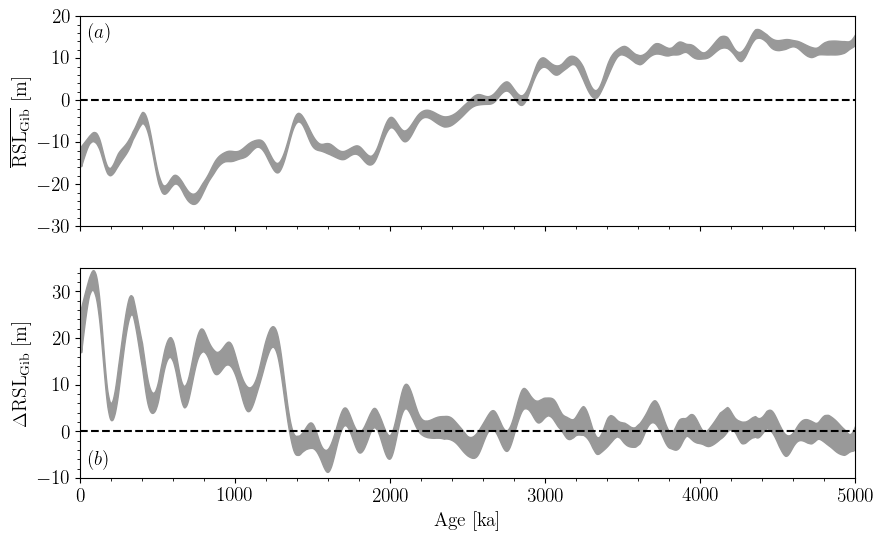

In [15]:
#Setup figure
fontsize = 14
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,figsize=(10,6))

#Plot (a)
ax1.fill_between(age,BslSM[:,0]-1.96*BslSM[:,1],BslSM[:,0]+1.96*BslSM[:,1],color=[0.6,0.6,0.6])
ax1.set_xlim([0,5000])
ax1.set_ylim([-30,20])
ax1.plot([0,5000],[0,0],'--k')
ax1.minorticks_on()
ax1.tick_params(axis='both', which='major', labelsize=fontsize)
ax1.set_ylabel(r"$\overline{\mathrm{RSL}_{\mathrm{Gib}}}$  $[\mathrm{m}]$", fontsize=fontsize)
ax1.text(50,15,r"$(a)$",fontsize=fontsize)

#Plot (b)
ax2.fill_between(age,DslSM[:,0]-1.96*DslSM[:,1],DslSM[:,0]+1.96*DslSM[:,1],color=[0.6,0.6,0.6])
ax2.set_xlim([0,5000])
ax2.set_ylim([-10,35])
ax2.plot([0,5000],[0,0],'--k')
ax2.minorticks_on()
ax2.tick_params(axis='both', which='major', labelsize=fontsize)
ax2.set_ylabel(r"$\Delta \mathrm{RSL}_{\mathrm{Gib}}$  $[\mathrm{m}]$", fontsize=fontsize)
ax2.set_xlabel(r"$\mathrm{Age~[ka]}$", fontsize=fontsize);
ax2.text(50,-7,r"$(b)$",fontsize=fontsize);

#Uncomment next two lines to save figure
#plt.tight_layout()
#plt.savefig('Figure5.pdf')

#### Transform difference in $\Delta$RSL$_{Gib}$ to corresponding change in $\delta^{18}O_{\textrm{pf}}$ according to the Summer - Winter box model of Rohling (1999, 2004) 

In [16]:
Sens = 1.48636214e-05*BslSM[:,1]-1.91620239e-02 #Sensivitity obtained from box model as a function of RSL_Gib
Sens_err = 0.00064 #Sensivitity standard error

DdcHAT = np.zeros((np.size(age),2))
DdcHAT[:,0] = DslSM[:,0] * Sens #estimated contribution of RSLGib
DdcHAT[:,1] = np.sqrt((Sens*DslSM[:,1])**2+(DslSM[:,0]*Sens_err)**2) #standard error on estimate

#### Estimate marl $Q^{\delta^{18}O_{\textrm{pf}}}_{\textrm{pf}}(M)$ combined with sea-level contribution $\Delta \delta^{18}\textrm{O}^\textrm{RSLGib}_{\textrm{pf}}$
This represents an estimate of what the sapropel interval $\delta^{18}O_{\textrm{pf}}$ would be if $\Delta$FWF and $\Delta$T are zero.

In [17]:
Mhat = np.zeros((np.size(age),2))
Mhat[:,0] = dcM10[0](age)+DdcHAT[:,0] #combined estimate
Mhat[:,1] = np.sqrt(dcM10[1](age)**2+DdcHAT[:,1]**2) #standard error on estimate

### Recreate Figure 6
#### Plot of $\delta^{18}O_{\textrm{pf}}$ quantiles as bands (representing 95% uncertainty as $\pm$1.96 se)
Blue = $\delta^{18}O_{\textrm{pf}}$ in sapropels

Black = $\delta^{18}O_{\textrm{pf}}$ in sapropels

Orange = 0.1 quantile of $\delta^{18}O_{\textrm{pf}}$ in marls

Green = 0.1 quantile of $\delta^{18}O_{\textrm{pf}}$ in sapropels

Red = Sum of 0.1 quantile of $\delta^{18}O_{\textrm{pf}}$ in marls and estimated $\Delta \textrm{RSL}_{\textrm{Gib}}$ contribution

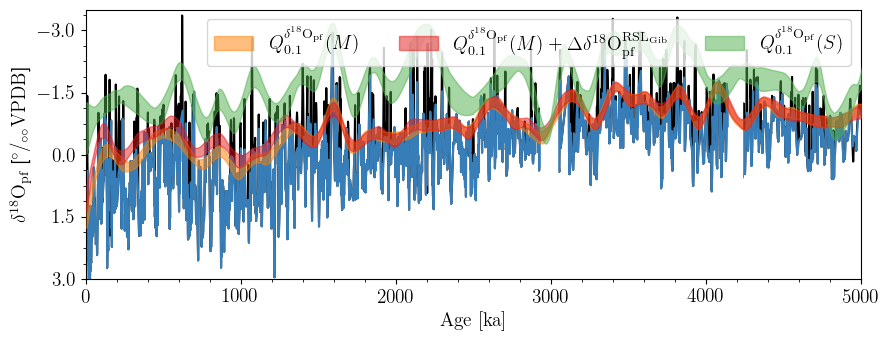

In [18]:
#Set up figure
fontsize=14
fig, ax1 = plt.subplots(figsize=(10,3.5))

#Make plot
ax1.plot(age,dc,'k',zorder=1)
ax1.plot(age[Midx==1],dc[Midx==1],color=CB[0],zorder=2)
ax1.set_xlim([0,5000])
ax1.fill_between(age,dcM10[0](age)-1.96*dcM10[1](age),dcM10[0](age)+1.96*dcM10[1](age),color=CB[1],zorder=4,alpha=0.5,label=r"$Q_{0.1}^{\delta^{18}\mathrm{O_{pf}}} (M)$")
ax1.fill_between(age,Mhat[:,0]-1.96*Mhat[:,1],Mhat[:,0]+1.96*Mhat[:,1],color=CB[7],zorder=4,alpha=0.5,label=r"$Q_{0.1}^{\delta^{18}\mathrm{O_{pf}}} (M) + \Delta \delta^{18}\mathrm{O}_{\mathrm{pf}}^\mathrm{{RSL_{Gib}}}$")
ax1.fill_between(age,dcS10[0](age)-1.96*dcS10[1](age),dcS10[0](age)+1.96*dcS10[1](age),color=CB[2],zorder=5,alpha=0.5,label=r"$Q_{0.1}^{\delta^{18}\mathrm{O_{pf}}} (S)$")
ax1.set_ylim([-3.5,3])
ax1.fill_between(H[0,:],[-3.0,-3.0],[2,2],color='w',zorder=3)
ax1.fill_between(H[1,:],[-3.0,-3.0],[2,2],color='w',zorder=3)
ax1.legend(fontsize=fontsize,ncol=3)
ax1.set_yticks(np.arange(-3,3.1,1.5))
ax1.invert_yaxis()
ax1.set_ylabel(r"$\delta^{18}\mathrm{O_{pf}}$ [$^\circ / _{\circ\circ} \mathrm{VPDB}$]", fontsize=fontsize)
ax1.minorticks_on()
ax1.tick_params(axis='both', which='major', labelsize=fontsize)
ax1.set_xlabel(r"$\mathrm{Age~[ka]}$", fontsize=fontsize);

#Uncomment next two lines to save figure
#plt.tight_layout()
#plt.savefig('Figure6.pdf')

#### Estimate difference between expected and observed sapropel $\delta^{18}O_{\textrm{pf}}$ to give $\Delta \delta^{18}O^{\textrm{mon}}_{\textrm{pf}}$
This difference represents the $\delta^{18}O_{\textrm{pf}}$ anomaly due to monsoon FWF and temperature concentration effects

In [19]:
DdcSM = np.zeros((np.size(age),2))
DdcSM[:,0] = dcS10[0](age)-Mhat[:,0] #estimated anomaly
DdcSM[:,1] = np.sqrt(dcS10[1](age)**2+Mhat[:,1]**2) #estimated standard error

#### Define relationship of  $\Delta \delta^{18}O^{\textrm{mon}}_{\textrm{pf}}$ to $\Delta$FWF and $\Delta$T according to box-model sensitivities.
The following functions are used to make additional y-axes ($\Delta$FWF and $\Delta$T) in Figure 7

In [20]:
def dc2T(x):
    return x/-0.2209732959

def T2dc(x):
    return x*-0.2209732959

def dc2FWF(x):
    return x/-0.28169732
    
def FWF2dc(x):
    return x*-0.28169732

### Recreate Figure 7

#### Top panel (a) - plot of $\Delta \delta^{18}O^{\textrm{mon}}_{\textrm{pf}}$ anomaly in sapropels due to with corresponding $\Delta$FWF and $\Delta$T scales (shading represents 95% uncertainty)
#### Bottom panel (b) - Eccentricity record of Laskar et al. (2004)

Blue = Eccentricity

Orange = 0.5 quantile of eccentricity represented by a smoothing cubic spline (dof=50)

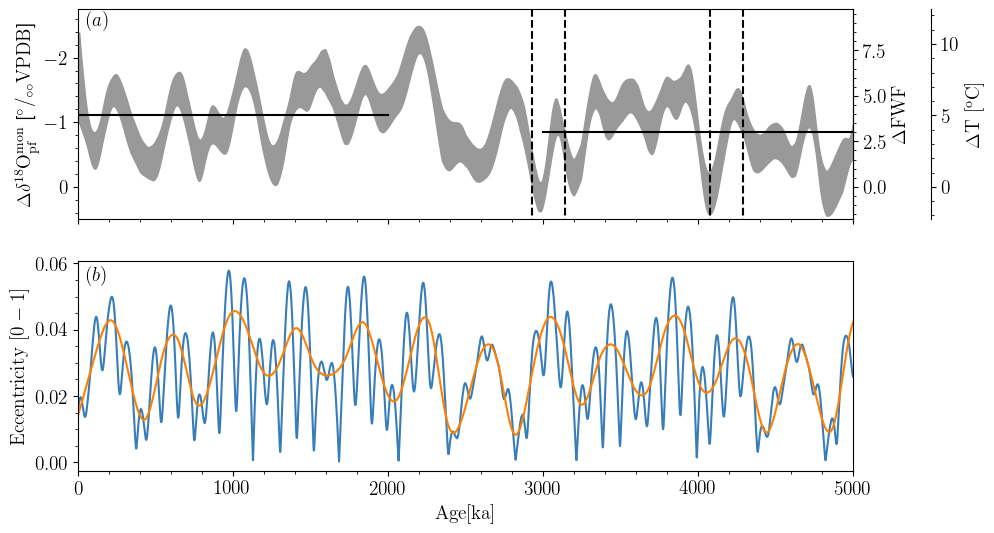

In [21]:
#Set up figure
fontsize = 14
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,figsize=(10,6))

#Plot (a)
ax1.fill_between(age,DdcSM[:,0]-1.96*DdcSM[:,1],DdcSM[:,0]+1.96*DdcSM[:,1],color=[0.6,0.6,0.6])
ax1.set_xlim([0,5000])
ax1.set_ylim([-2.75,0.5])
ax1.set_ylabel(r"$\Delta\delta^{18}\mathrm{O}^\mathrm{mon}_\mathrm{pf}$ [$^\circ / _{\circ\circ} \mathrm{VPDB}$]", fontsize=fontsize)
ax1.minorticks_on()
ax1.tick_params(axis='both', which='major', labelsize=fontsize)
ax1.invert_yaxis()
ax1.text(50,-2.5,r"$(a)$",fontsize=fontsize)


for i in range(2):
    ax1.plot([K[i,0],K[i,0]],[-2.75,0.5],"--k")
    ax1.plot([K[i,1],K[i,1]],[-2.75,0.5],"--k")
    
bar1 = np.mean(DdcSM[age<2000,0])    
ax1.plot([0,2000],[bar1,bar1],'-k')

bar2 = np.mean(DdcSM[age>3000,0])    
ax1.plot([3000,5000],[bar2,bar2],'-k')

#Add Delta FWF axis
secax_y1 = ax1.secondary_yaxis('right', functions=(dc2FWF, FWF2dc))
secax_y1.set_ylabel(r'$\Delta\mathrm{FWF}$', fontsize=fontsize)
secax_y1.tick_params(axis='both', which='major', labelsize=fontsize)
secax_y1.minorticks_on()

#Add Delta T axis
secax_y2 = ax1.secondary_yaxis(1.1, functions=(dc2T, T2dc))
secax_y2.set_ylabel(r'$\Delta\mathrm{T}\ [\mathrm{^oC}]$',fontsize=fontsize)
secax_y2.tick_params(axis='both', which='major', labelsize=fontsize)
secax_y2.minorticks_on()

#plot (b)
ax2.plot(X[:,0],X[:,1],color=CB[0])
ax2.plot(X[:,0],E50[0](X[:,0]),color=CB[1])
ax2.set_xlabel(r"$\mathrm{Age [ka]}$", fontsize=fontsize);
ax2.minorticks_on()
ax2.tick_params(axis='both', which='major', labelsize=fontsize)
ax2.set_ylabel(r"$\mathrm{Eccentricity~[0-1]}$", fontsize=fontsize);
ax2.text(50,0.055,r"$(b)$",fontsize=fontsize);

#Uncomment next two lines to save figure
#plt.tight_layout()
#plt.savefig('Figure7.pdf')